# Analysis 2: Are youth programs in Chicago fairly distrubuted across different cultures?
*By Sofie Langenhuizen*

In [156]:
#importing necessary libraries and reading data 

import pandas as pd
import geopandas as gpd
import geodatasets
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from langdetect import detect
import numpy as np

my_chi_data = pd.read_csv('../My_CHI._My_Future._Programs.csv')
in_person_events_only = pd.read_csv('../in_person_events_with_zip_clean.csv', index_col='Unnamed: 0')
language_data = pd.read_csv('../Census_Data_-_Languages_spoken_in_Chicago__2008___2012.csv')
ethnicity_data = pd.read_csv('../Chicago_Population_Counts_20241204.csv')
chicago = gpd.read_file('../geo_export_d9493742-459b-40a5-a579-3a46b588f0d5.shp')
comm_areas = gpd.read_file(geodatasets.get_path("geoda.chicago_commpop"))

In [157]:
#data cleaning

#drop unnecessary columns
my_chi_data = my_chi_data.drop(columns=['Org Name',
       'Category Name', 'Capacity', 'Address', 'City',
       'State', 'Program Type', 'Program URL', 'Online Address',
       'Registration URL', 'Registration Open', 'Registration Deadline',
       'Start Date', 'End Date', 'Start Time', 'End Time', 'Contact Name',
       'Contact Email', 'Contact Phone', 'Program Price',
       'Geographic Cluster Name', 'Scholarship Available', 'Participants Paid',
       'Image', 'Hidden Programs', 'Featured', 'Custom Categories', 'Tag'])
in_person_events_only = in_person_events_only.drop(columns=['Org Name',
       'Category Name', 'Capacity', 'Address', 'City',
       'State', 'Program Type', 'Program URL', 'Online Address',
       'Registration URL', 'Registration Open', 'Registration Deadline',
       'Start Date', 'End Date', 'Start Time', 'End Time', 'Contact Name',
       'Contact Email', 'Contact Phone', 'Program Price',
       'Geographic Cluster Name', 'Scholarship Available', 'Participants Paid',
       'Image',
       'Hidden Programs', 'Featured', 'Custom Categories', 'Tag'])
ethnicity_data = ethnicity_data.drop(columns=[
       'Population - Age 0-17', 'Population - Age 18-29',
       'Population - Age 30-39', 'Population - Age 40-49',
       'Population - Age 50-59', 'Population - Age 60-69',
       'Population - Age 70-79', 'Population - Age 80+',
       'Population - Age 0-4', 'Population - Age 5-11',
       'Population - Age 12-17', 'Population - Age 5+', 'Population - Age 18+',
       'Population - Age 65+', 'Population - Female', 'Population - Male'])


#drop duplicate program IDs
my_chi_data = my_chi_data.drop_duplicates('Program ID')
in_person_events_only = in_person_events_only.drop_duplicates('Program ID')

#filter down to only youth programs
my_chi_data = my_chi_data.loc[my_chi_data['Min Age'] <= 25]
in_person_events_only = in_person_events_only.loc[in_person_events_only['Min Age'] <= 25]

#filter ethnicity data down to only the most recent year and to only ZIP Code geography types
ethnicity_data = ethnicity_data.loc[(ethnicity_data['Year'] == 2021) & ~(ethnicity_data['Geography Type'] == 'Citywide')]

#change language dataset to have comm area as all caps
language_data['Community Area Name'] = language_data['Community Area Name'].str.upper()

#clean up zip code data type for future use
chicago['zip'] = pd.to_numeric(chicago['zip'])
ethnicity_data['Geography'] = pd.to_numeric(ethnicity_data['Geography'])

#impute community areas for my chi dataset

#create geodataframe out of inperson events containing only longitude and latitude
in_person_gdf = gpd.GeoDataFrame(
    in_person_events_only, geometry=gpd.points_from_xy(in_person_events_only.Longitude, in_person_events_only.Latitude), crs="EPSG:4326"
)

#join the community area name to the in person event based on whether the coordinates are withing the community polygon
joined_gdf = gpd.sjoin(in_person_gdf, comm_areas.loc[:,['geometry','community']], how='left', predicate='within')

#add community area name to each in person event in main df
in_person_events_only = pd.merge(
                            left=in_person_events_only,
                            right=joined_gdf.loc[:,['Program ID', 'community']], 
                            left_on='Program ID', 
                            right_on='Program ID',
                            how='left'
)

#condense my chi data and cleaned in person events into one clean dataset

#isolate online programs
online_programs = my_chi_data.loc[my_chi_data['Meeting Type'] == 'online']

#concate with the clean in person data from above
clean_my_chi_data = pd.concat([online_programs, in_person_events_only], axis=0)
clean_my_chi_data = clean_my_chi_data.reset_index(drop=True)

In [158]:
#determine which language the program is taught in or about

#define keywords that may be included in an english description, yet indicate the focus of the course to be on one of the top three languages
spanish_keywords = ['spanish', 'espanol', 'español', 'latino', 'latina', 'latine', 'latinx', 'spain', 'latin america', 'hispanic', 'hispano']
polish_keywords = ['polish', 'polski', 'poland']
chinese_keywords = ['chinese', 'mandarin', 'cantonese', 'china']

#detect language that the description is written in for each program
language_tracking = clean_my_chi_data.loc[:, ['Program ID', 'ZIP Code', 'community', 'Program Name', 'Meeting Type', 'Description', 'Transport Provided', 'Has Free Food']]
language_tracking['lang_detected'] = language_tracking['Description'].apply(lambda x: detect(x))

#check if each program is in or about Spanish
language_tracking['Spanish'] = (
    language_tracking.apply(lambda row: 1 if (any(item in row['Description'].lower() for item in spanish_keywords) 
                              | any(item in row['Program Name'].lower() for item in spanish_keywords)
                              | (row['lang_detected'] == 'es'))
                            else 0, axis=1)
)

#check if each program is in or about Polish
language_tracking['Polish'] = (
    language_tracking.apply(lambda row: 1 if (any(item in row['Description'].lower() for item in polish_keywords) 
                            | any(item in row['Program Name'].lower() for item in polish_keywords)
                            | (row['lang_detected'] == 'pl'))
                            else 0, axis=1)
)

#check if each program is in or about Chinese
language_tracking['Chinese'] = (
    language_tracking.apply(lambda row: 1 if (any(item in row['Description'].lower() for item in chinese_keywords) 
                            | any(item in row['Program Name'].lower() for item in chinese_keywords)
                            | (row['lang_detected'] == 'zh-tw')
                            | (row['lang_detected'] == 'zh-cn'))
                            else 0, axis=1)
)

#create indicator for any one of the top 3 languagaes
language_tracking['Top 3 Language Indicator'] = language_tracking.loc[:,['Spanish', 'Polish', 'Chinese']].apply(lambda row:
                                                                        1 if sum(row) > 0 else 0, axis=1)

In [159]:
#customize shape files with new columns and merging

#ZIP Code shape file

#merge chicago shape file with ethnicity data to get ethnicity counts by ZIP
chicago = pd.merge(left=chicago, 
                   right=ethnicity_data.loc[:,['Geography', 'Population - Latinx', 'Population - Asian Non-Latinx', 'Population - Black Non-Latinx', 'Population - Total']], 
                    left_on=['zip'],
                    right_on=['Geography'],
                    how='left')

#calculate the total non-white population
chicago['Total Non-White Population'] = chicago.loc[:,['Population - Latinx', 'Population - Asian Non-Latinx', 'Population - Black Non-Latinx']].apply(lambda row: sum(row), axis=1)

#calculate proportion of total population that is non-white
chicago['Proportion Non-White'] = chicago['Total Non-White Population'] / chicago['Population - Total']

#add count of programs by zip code
in_person_data_grouped_zip = in_person_events_only.groupby('ZIP Code')['Program ID'].agg(['count'])
chicago = pd.merge(left=chicago, 
                   right=in_person_data_grouped_zip, 
                    left_on=['zip'],
                    right_on=['ZIP Code'],
                    how='left')
chicago = chicago.rename(columns={'count': 'num_programs'})

#community area shape file

#merge comm area shape file with language info to get langauge counts by Community Area
comm_areas = pd.merge(left=comm_areas, 
                   right=language_data.loc[:,['Community Area Name', 'PREDOMINANT NON-ENGLISH LANGUAGE (%)', 'SPANISH', 'POLISH', 'CHINESE']], 
                    left_on=['community'],
                    right_on=['Community Area Name'],
                    how='left')

#create total column
comm_areas['Total Speaking Top 3'] = comm_areas.loc[:,['SPANISH', 'POLISH', 'CHINESE']].apply(lambda row: sum(row), axis=1)

#find the proportion speaking the top 3 languages better than english based on total population
comm_areas['Proportion Speaking Top 3'] = comm_areas['Total Speaking Top 3'] / comm_areas['POP2010']

#add count of programs by community area 
in_person_data_grouped = in_person_events_only.groupby('community')['Program ID'].agg(['count'])
in_person_data_grouped.reset_index(inplace=True)
comm_areas = pd.merge(left=comm_areas, 
                   right=in_person_data_grouped, 
                    left_on=['community'],
                    right_on=['community'],
                    how='left')
comm_areas = comm_areas.rename(columns={'count': 'num_programs'})

#count the number of programs for each language by community
grouped_language_programs = language_tracking.groupby('community')[['Spanish','Polish','Chinese','Top 3 Language Indicator']].sum()
grouped_language_programs = grouped_language_programs.reset_index()
comm_areas = pd.merge(left=comm_areas, 
                   right=grouped_language_programs, 
                    left_on=['community'],
                    right_on=['community'],
                    how='left')
comm_areas = comm_areas.rename(columns = {'Spanish': 'spanish_programs', 'Polish': 'polish_programs', 'Chinese': 'chinese_programs'})

#find the percent of total speakers and programs in each area for each language
spanish_speakers = comm_areas.loc[:,'SPANISH'].sum()
spanish_programs = comm_areas.loc[:,'spanish_programs'].sum()
comm_areas['Percent of Total Spanish Speakers'] = (comm_areas.loc[:,'SPANISH'] / spanish_speakers) *100
comm_areas['Percent of Total Spanish Programs'] = (comm_areas.loc[:,'spanish_programs'] / spanish_programs) * 100

polish_speakers = comm_areas.loc[:,'POLISH'].sum()
polish_programs = comm_areas.loc[:,'polish_programs'].sum()
comm_areas['Percent of Total Polish Speakers'] = (comm_areas.loc[:,'POLISH'] / polish_speakers) *100
comm_areas['Percent of Total Polish Programs'] = (comm_areas.loc[:,'polish_programs'] / polish_programs) * 100

chinese_speakers = comm_areas.loc[:,'CHINESE'].sum()
chinese_programs = comm_areas.loc[:,'chinese_programs'].sum()
comm_areas['Percent of Total Chinese Speakers'] = (comm_areas.loc[:,'CHINESE'] / chinese_speakers) *100
comm_areas['Percent of Total Chinese Programs'] = (comm_areas.loc[:,'chinese_programs'] / chinese_programs) * 100

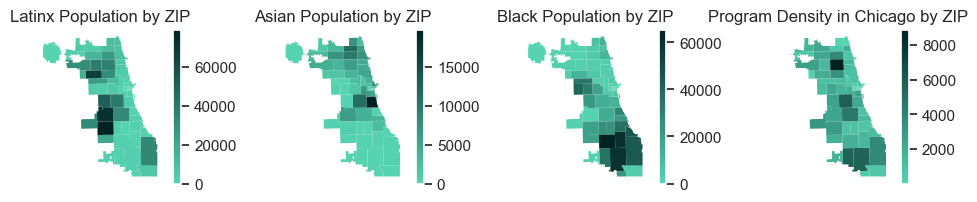

In [211]:
#plot non-white ethnicity groups by zip code, and program density by zip code

#creating color map for group theme
colors = ['#56d4b2', '#002223']
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

#create grid of 1x3 axes
fig, ax = plt.subplots(1, 4, figsize=(12, 2))

#plot three Non-White groups from census data
chicago.plot(column='Population - Latinx', ax=ax[0], legend=True, cmap=cmap, edgecolor='none')
chicago.plot(column='Population - Asian Non-Latinx', ax=ax[1], legend=True, cmap=cmap, edgecolor='none')
chicago.plot(column='Population - Black Non-Latinx', ax=ax[2], legend=True, cmap=cmap, edgecolor='none')
#plot number of programs by zip
chicago.plot(column='num_programs', ax=ax[3], legend=True, cmap=cmap, edgecolor='none')

#remove axes for cleaner look
for i in range(4):
    ax[i].set_axis_off()

#add titles to each axes
ax[0].set_title('Latinx Population by ZIP', size=12)
ax[1].set_title('Asian Population by ZIP', size=12)
ax[2].set_title('Black Population by ZIP', size=12)
ax[3].set_title('Program Density in Chicago by ZIP', size=12)

plt.show()

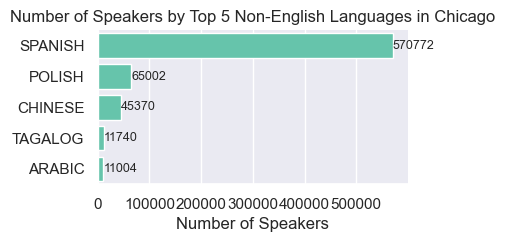

In [206]:
#plot number of speakers by Non-English language

#sum all speakers of each of the languages, sort most to least spoken
language_speakers = language_data.iloc[:,3:].apply(lambda col: sum(col))
language_speakers = language_speakers.sort_values(ascending=False)

#plot the first five (five most spoken) languages by speaker
fig, ax = plt.subplots(figsize=(4,2))
sns.barplot(language_speakers[0:5], ax=ax, orient='h', color='#56d4b2')
ax.set_title('Number of Speakers by Top 5 Non-English Languages in Chicago')
ax.bar_label(ax.containers[0],label_type='edge', size=9)
ax.set_xlabel('Number of Speakers')
sns.despine()

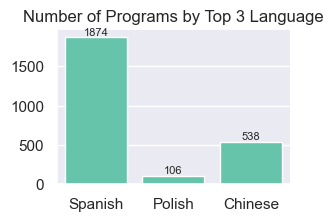

In [203]:
#graph number of programs by the top 3 langauges identified
fig, ax = plt.subplots(figsize=(3,2))
sns.barplot(language_tracking.iloc[:,9:12].sum(), ax=ax, orient='v', color='#56d4b2')
ax.set_title('Number of Programs by Top 3 Language', size=12)
ax.bar_label(ax.containers[0],label_type='edge', size=8)
sns.despine()

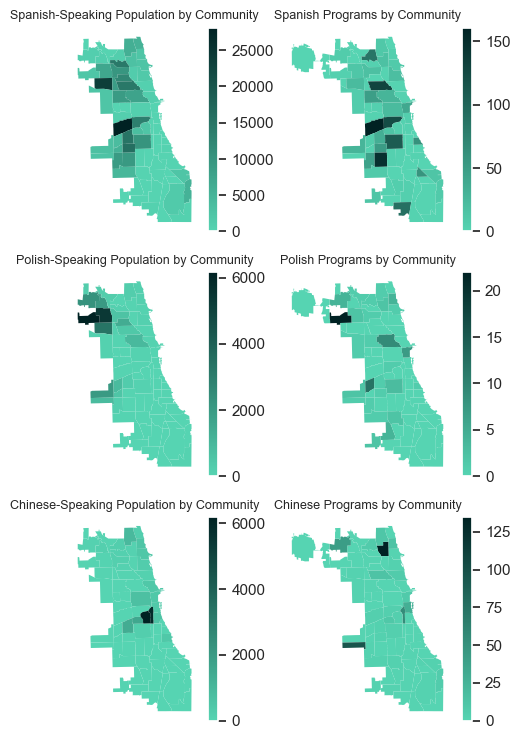

In [164]:
#graph language speaking population compared to language programs by community for each of top 3

#create 3x2 grid of axes
fig, ax = plt.subplots(3, 2, figsize=(6, 9))

#plot population of language speakers and density of language programs by community
comm_areas.plot(column='SPANISH', ax=ax[0,0], legend=True, cmap=cmap, edgecolor='none')
comm_areas.plot(column='spanish_programs', ax=ax[0,1], legend=True, cmap=cmap, edgecolor='none')
comm_areas.plot(column='POLISH', ax=ax[1,0], legend=True, cmap=cmap, edgecolor='none')
comm_areas.plot(column='polish_programs', ax=ax[1,1], legend=True, cmap=cmap, edgecolor='none')
comm_areas.plot(column='CHINESE', ax=ax[2,0], legend=True, cmap=cmap, edgecolor='none')
comm_areas.plot(column='chinese_programs', ax=ax[2,1], legend=True, cmap=cmap, edgecolor='none')

#remove axes for cleaner look
for i in range(3):
    for j in range(2):
        ax[i,j].set_axis_off()

#add title to each axes
ax[0,0].set_title('Spanish-Speaking Population by Community', size = 9)
ax[0,1].set_title('Spanish Programs by Community', size = 9)
ax[1,0].set_title('Polish-Speaking Population by Community', size = 9)
ax[1,1].set_title('Polish Programs by Community', size = 9)
ax[2,0].set_title('Chinese-Speaking Population by Community', size = 9)
ax[2,1].set_title('Chinese Programs by Community', size = 9)

plt.show()

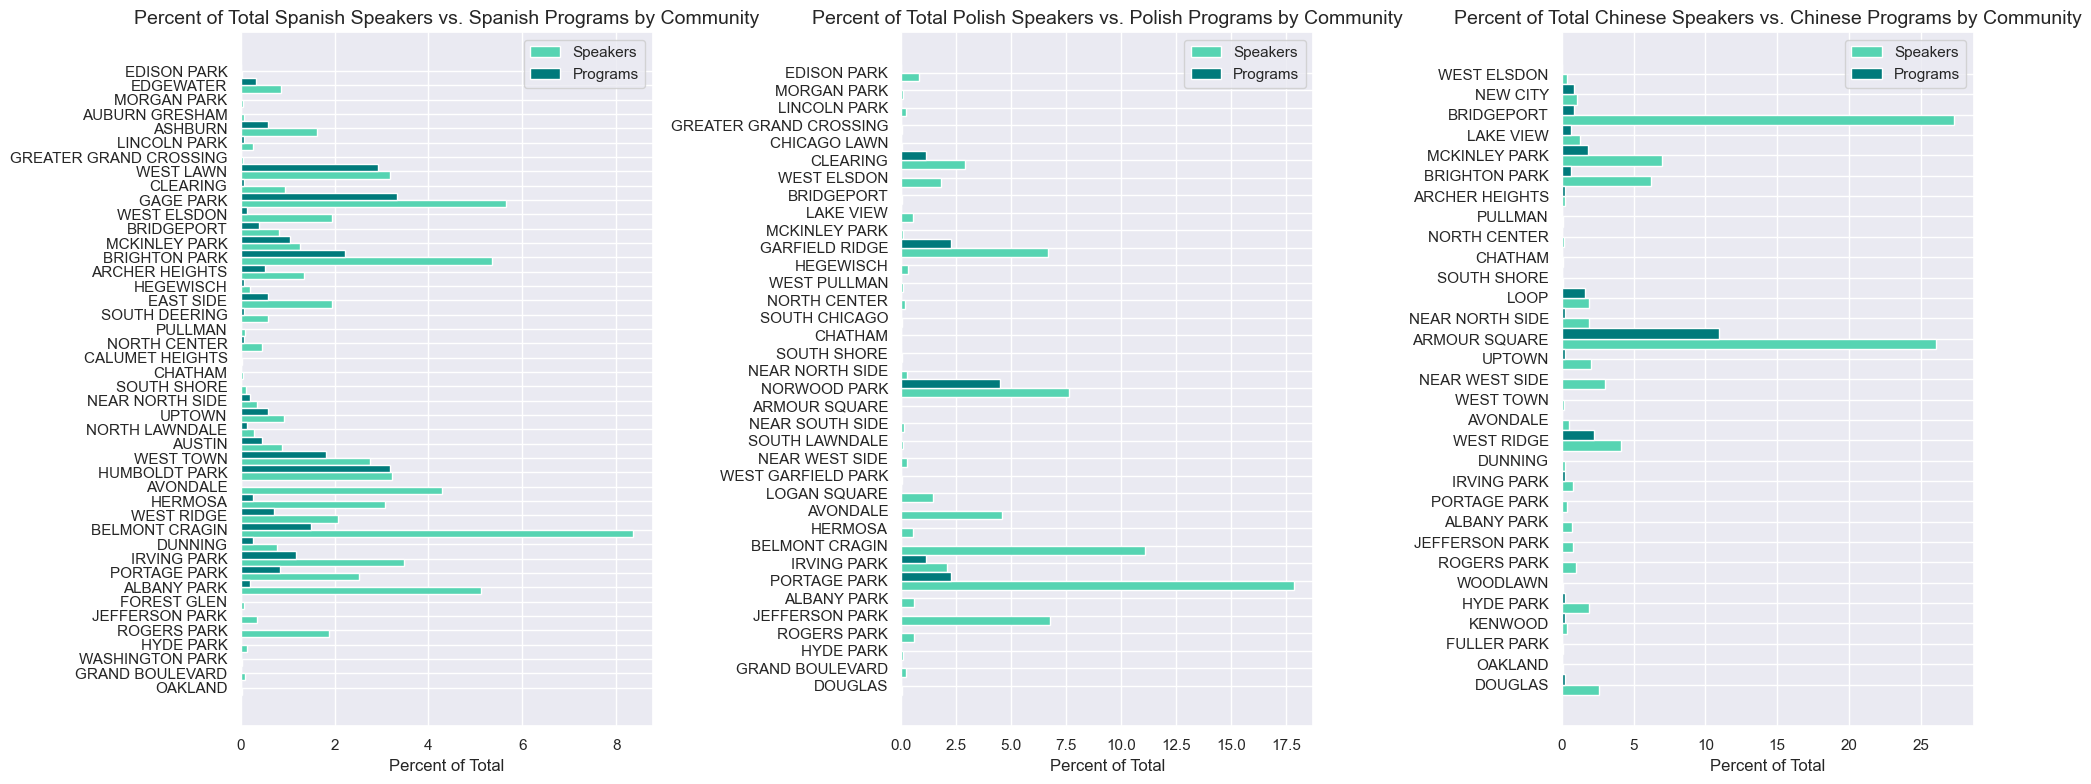

In [213]:
#graph percentage of total language speakers vs percentage of total language programs by community for each of the top areas

#create datasets that only show communities that have higher precentages of speakers than of programs
sp_filtered_data = comm_areas.loc[(comm_areas['Percent of Total Spanish Speakers'] > comm_areas['Percent of Total Spanish Programs'])]
pl_filtered_data = comm_areas.loc[(comm_areas['Percent of Total Polish Speakers'] > comm_areas['Percent of Total Polish Programs'])]
ch_filtered_data = comm_areas.loc[(comm_areas['Percent of Total Chinese Speakers'] > comm_areas['Percent of Total Chinese Programs'])]

#create spots for each of the labels 
sp_y = np.arange(len(sp_filtered_data)) 
pl_y = np.arange(len(pl_filtered_data))
ch_y = np.arange(len(ch_filtered_data)) 
height = 0.5  #set width of bars

#create 1x3 grid of axes
fig, ax = plt.subplots(1, 3, figsize=(20,8))

#add bars for each language
sp_bars1 = ax[0].barh(sp_y - height / 2, sp_filtered_data['Percent of Total Spanish Speakers'], height, label="Speakers", color='#56d4b2')
sp_bars2 = ax[0].barh(sp_y + height / 2, sp_filtered_data['Percent of Total Spanish Programs'], height, label="Programs", color='#007A7B')

pl_bars1 = ax[1].barh(pl_y - height / 2, pl_filtered_data['Percent of Total Polish Speakers'], height, label="Speakers", color='#56d4b2')
pl_bars2 = ax[1].barh(pl_y + height / 2, pl_filtered_data['Percent of Total Polish Programs'], height, label="Programs", color='#007A7B')

ch_bars1 = ax[2].barh(ch_y - height / 2, ch_filtered_data['Percent of Total Chinese Speakers'], height, label="Speakers", color='#56d4b2')
ch_bars2 = ax[2].barh(ch_y + height / 2, ch_filtered_data['Percent of Total Chinese Programs'], height, label="Programs", color='#007A7B')

#add labels, title, and legend for each language
for i in range(3):
    ax[i].set_xlabel("Percent of Total")
    ax[i].legend()

#add titles and ylabels for each of the graphs
ax[0].set_title("Percent of Total Spanish Speakers vs. Spanish Programs by Community", size=14)
ax[0].set_yticks(sp_y)
ax[0].set_yticklabels(sp_filtered_data['community'])

ax[1].set_title("Percent of Total Polish Speakers vs. Polish Programs by Community", size=14)
ax[1].set_yticks(pl_y)
ax[1].set_yticklabels(pl_filtered_data['community'])

ax[2].set_title("Percent of Total Chinese Speakers vs. Chinese Programs by Community", size=14)
ax[2].set_yticks(ch_y)
ax[2].set_yticklabels(ch_filtered_data['community'])

plt.tight_layout()
plt.show()


In [166]:
#| output: false
#calculate percentages of each language category of programs that fit different accessibility markers

#find total number of progams for each language
polish_programs = language_tracking.loc[language_tracking['Polish'] == 1]
spanish_programs = language_tracking.loc[language_tracking['Spanish'] == 1]
chinese_programs = language_tracking.loc[language_tracking['Chinese'] == 1]
multilingual_programs = language_tracking.loc[language_tracking['Top 3 Language Indicator'] == 1]

#calculate online percentages
try: s_online_pct = round((spanish_programs['Meeting Type'].value_counts()[1] / spanish_programs.shape[0] * 100), ndigits=2)
except: s_online_pct = 0

try: p_online_pct = round((polish_programs['Meeting Type'].value_counts()[1] / polish_programs.shape[0] * 100), ndigits=2)
except: p_online_pct = 0

try: c_online_pct = round((chinese_programs['Meeting Type'].value_counts()[1] / chinese_programs.shape[0] * 100), ndigits=2)
except: c_online_pct = 0

try: m_online_pct = round((multilingual_programs['Meeting Type'].value_counts()[1] / multilingual_programs.shape[0] * 100), ndigits=2)
except: m_online_pct = 0

#find total number of in person programs for each language
spanish_programs_inperson = spanish_programs.loc[spanish_programs['Meeting Type'] == 'face_to_face']
polish_programs_inperson = polish_programs.loc[polish_programs['Meeting Type'] == 'face_to_face']
chinese_programs_inperson = chinese_programs.loc[chinese_programs['Meeting Type'] == 'face_to_face']
multilingual_programs_inperson = multilingual_programs.loc[multilingual_programs['Meeting Type'] == 'face_to_face']

#calculate transport provided percentages
try: s_transport_pct = round((spanish_programs_inperson['Transport Provided'].value_counts()[1] / spanish_programs_inperson.shape[0] * 100), ndigits=2)
except: s_transport_pct = 0

try: p_transport_pct = round((polish_programs_inperson['Transport Provided'].value_counts()[1] / polish_programs_inperson.shape[0] * 100), ndigits=2)
except: p_transport_pct = 0

try: c_transport_pct = round((chinese_programs_inperson['Transport Provided'].value_counts()[1] / chinese_programs_inperson.shape[0] * 100), ndigits=2)
except: c_transport_pct = 0

try: m_transport_pct = round((multilingual_programs_inperson['Transport Provided'].value_counts()[1] / multilingual_programs_inperson.shape[0] * 100), ndigits=2)
except: m_transport_pct = 0

#calculate free food percentages
try: s_free_food_pct = round((spanish_programs_inperson['Has Free Food'].value_counts()[1] / spanish_programs_inperson.shape[0] * 100), ndigits=2)
except: s_free_food_pct = 0

try: p_free_food_pct = round((polish_programs_inperson['Has Free Food'].value_counts()[1] / polish_programs_inperson.shape[0] * 100), ndigits=2)
except: p_free_food_pct = 0

try: c_free_food_pct = round((chinese_programs_inperson['Has Free Food'].value_counts()[1] / chinese_programs_inperson.shape[0] * 100), ndigits=2)
except: c_free_food_pct = 0

try: m_free_food_pct = round((multilingual_programs_inperson['Has Free Food'].value_counts()[1] / multilingual_programs_inperson.shape[0] * 100), ndigits=2)
except: m_free_food_pct = 0


/var/folders/tc/mjz8npv10cx4b8vxgmvz80fc0000gn/T/ipykernel_60344/2384372905.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  try: s_online_pct = round((spanish_programs['Meeting Type'].value_counts()[1] / spanish_programs.shape[0] * 100), ndigits=2)
/var/folders/tc/mjz8npv10cx4b8vxgmvz80fc0000gn/T/ipykernel_60344/2384372905.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  try: p_online_pct = round((polish_programs['Meeting Type'].value_counts()[1] / polish_programs.shape[0] * 100), ndigits=2)
/var/folders/tc/mjz8npv10cx4b8vxgmvz80fc0000gn/T/ipykernel_60344/2384372905.py:16: FutureWarning: Series.__getitem__ t

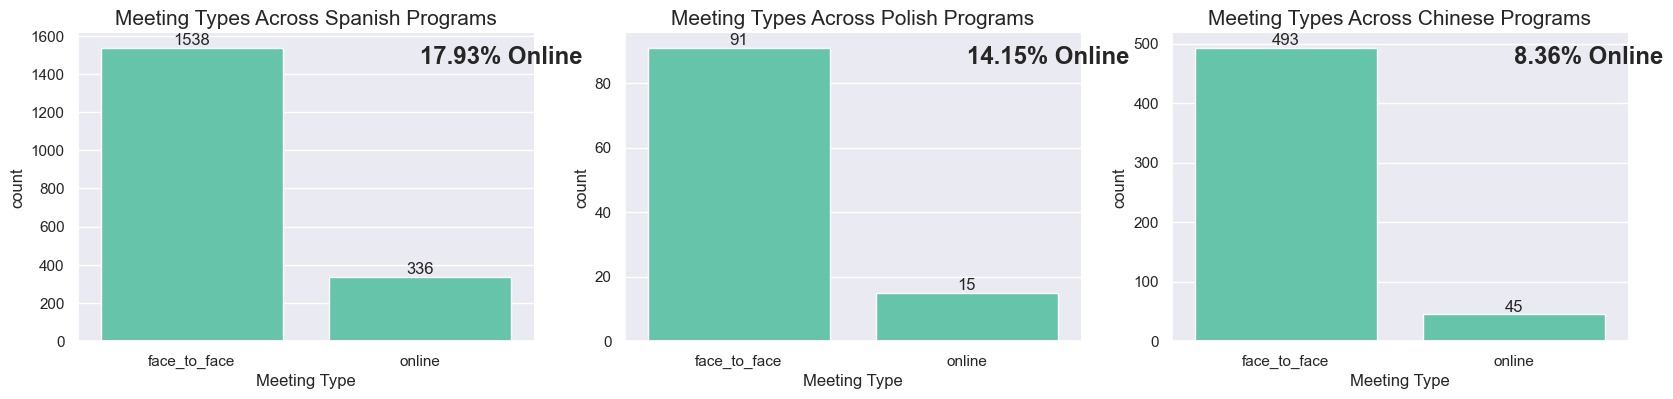

In [207]:
#graph online percentages by language

#create 1x3 grid of axes
fig, ax = plt.subplots(1,3, figsize=(20,4))

#plot meeting type counts for each language
sns.barplot(spanish_programs['Meeting Type'].value_counts(), ax=ax[0], orient='v',  color='#56d4b2')
sns.barplot(polish_programs['Meeting Type'].value_counts(), ax=ax[1], orient='v',  color='#56d4b2')
sns.barplot(chinese_programs['Meeting Type'].value_counts(), ax=ax[2], orient='v',  color='#56d4b2')

#add percentages as text on top
ax[0].text(0.75, 0.9, str(s_online_pct) + '% Online', transform=ax[0].transAxes, size='x-large', weight = 'bold')
ax[1].text(0.75, 0.9, str(p_online_pct) + '% Online', transform=ax[1].transAxes, size='x-large', weight = 'bold')
ax[2].text(0.75, 0.9, str(c_online_pct) + '% Online', transform=ax[2].transAxes, size='x-large', weight = 'bold')

#add title to each axes
ax[0].set_title('Meeting Types Across Spanish Programs', size = 15)
ax[1].set_title('Meeting Types Across Polish Programs', size = 15)
ax[2].set_title('Meeting Types Across Chinese Programs', size = 15)

#add labels to x axis
for i in range(3):
    ax[i].bar_label(ax[i].containers[0])

sns.despine()

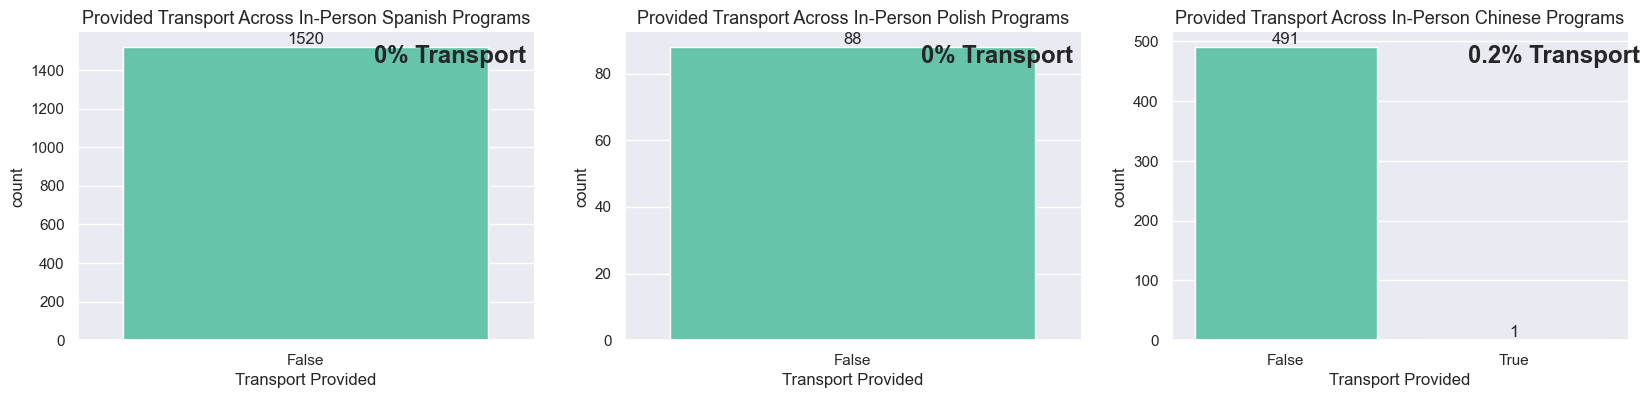

In [208]:
#graph transport provided percentages by language

#create 1x3 grid of axes
fig, ax = plt.subplots(1,3, figsize=(20,4))

#plot bars of Provided Transport values for each language's programs
sns.barplot(spanish_programs_inperson['Transport Provided'].value_counts(), ax=ax[0], orient='v',  color='#56d4b2')
sns.barplot(polish_programs_inperson['Transport Provided'].value_counts(), ax=ax[1], orient='v',  color='#56d4b2')
sns.barplot(chinese_programs_inperson['Transport Provided'].value_counts(), ax=ax[2], orient='v',  color='#56d4b2')

#add percentages as text on top
ax[0].text(0.65, 0.9, str(s_transport_pct) + '% Transport', transform=ax[0].transAxes, size='x-large', weight = 'bold')
ax[1].text(0.65, 0.9, str(p_transport_pct) + '% Transport', transform=ax[1].transAxes, size='x-large', weight = 'bold')
ax[2].text(0.65, 0.9, str(c_transport_pct) + '% Transport', transform=ax[2].transAxes, size='x-large', weight = 'bold')

#add titles to each of the axes
ax[0].set_title('Provided Transport Across In-Person Spanish Programs', size = 13)
ax[1].set_title('Provided Transport Across In-Person Polish Programs', size = 13)
ax[2].set_title('Provided Transport Across In-Person Chinese Programs', size = 13)

#add labels to x axis
for i in range(3):
    ax[i].bar_label(ax[i].containers[0])

sns.despine()

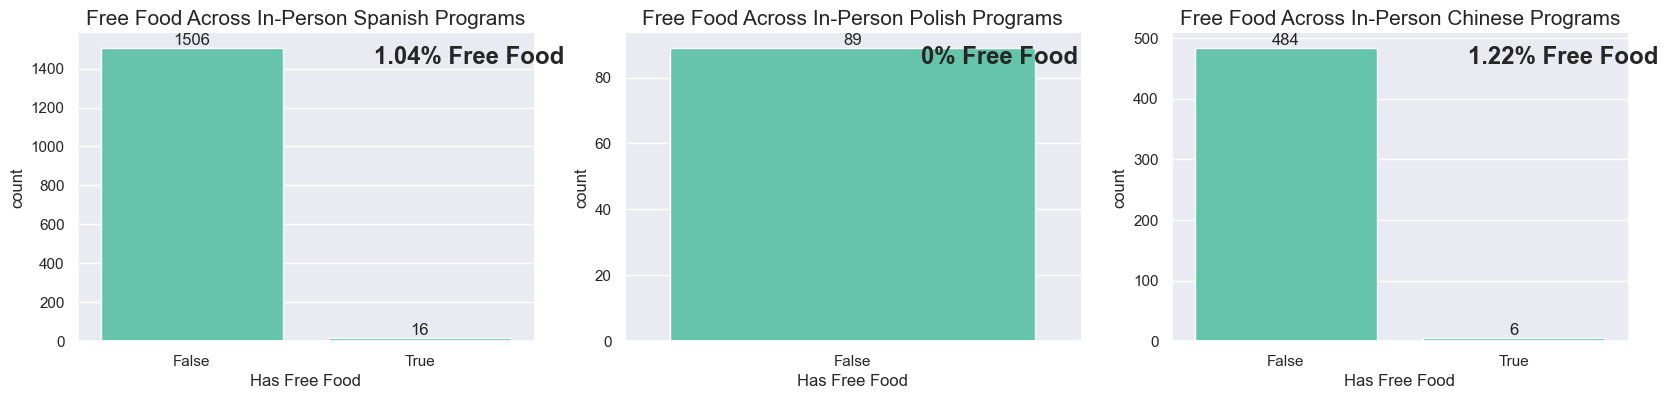

In [209]:
#graph free food percentages by language

#create 1x3 grid of axes
fig, ax = plt.subplots(1,3, figsize=(20,4))

#plot Has Free Food values for each language
sns.barplot(spanish_programs_inperson['Has Free Food'].value_counts(), ax=ax[0], orient='v',  color='#56d4b2')
sns.barplot(polish_programs_inperson['Has Free Food'].value_counts(), ax=ax[1], orient='v',  color='#56d4b2')
sns.barplot(chinese_programs_inperson['Has Free Food'].value_counts(), ax=ax[2], orient='v',  color='#56d4b2')

#add percentages as text on top
ax[0].text(0.65, 0.9, str(s_free_food_pct) + '% Free Food', transform=ax[0].transAxes, size='x-large', weight = 'bold')
ax[1].text(0.65, 0.9, str(p_free_food_pct) + '% Free Food', transform=ax[1].transAxes, size='x-large', weight = 'bold')
ax[2].text(0.65, 0.9, str(c_free_food_pct) + '% Free Food', transform=ax[2].transAxes, size='x-large', weight = 'bold')

#add titles to each of the axes
ax[0].set_title('Free Food Across In-Person Spanish Programs', size = 15)
ax[1].set_title('Free Food Across In-Person Polish Programs', size = 15)
ax[2].set_title('Free Food Across In-Person Chinese Programs', size = 15)

#add labels to x axis
for i in range(3):
    ax[i].bar_label(ax[i].containers[0])

sns.despine()

In [170]:
#create dummies for each other three accessibility points
online_dummies = pd.get_dummies(language_tracking['Meeting Type'], dtype=int)
free_food_dummies = pd.get_dummies(language_tracking['Has Free Food'], dtype=int)
transport_provided_dummies = pd.get_dummies(language_tracking['Transport Provided'], dtype=int)

#add dummies to the language tracking df
language_tracking['Online Dummy'] = online_dummies.loc[:,'online']
language_tracking['Has Free Food Dummy'] = free_food_dummies.iloc[:,1]
language_tracking['Transport Provided Dummy'] = transport_provided_dummies.iloc[:,1]

In [171]:
#print correlation between each of the accessibility measures and each of the languages
language_tracking.loc[:,['Spanish', 'Polish', 'Chinese', 'Top 3 Language Indicator', 'Online Dummy', 'Has Free Food Dummy', 'Transport Provided Dummy']].corr()

,Spanish,Polish,Chinese,Top 3 Language Indicator,Online Dummy,Has Free Food Dummy,Transport Provided Dummy
Spanish,1.000000,-0.001762,0.015076,0.864562,0.054431,0.005391,-0.002472
Polish,-0.001762,1.000000,-0.002144,0.203984,0.008330,-0.002376,-0.000583
Chinese,0.015076,-0.002144,1.000000,0.460444,0.003204,0.004760,0.005518
Top 3 Language Indicator,0.864562,0.203984,0.460444,1.000000,0.050280,0.006539,0.000344
Online Dummy,0.054431,0.008330,0.003204,0.050280,1.000000,-0.014194,-0.003429
Has Free Food Dummy,0.005391,-0.002376,0.004760,0.006539,-0.014194,1.000000,0.134368
Transport Provided Dummy,-0.002472,-0.000583,0.005518,0.000344,-0.003429,0.134368,1.000000


<Axes: >

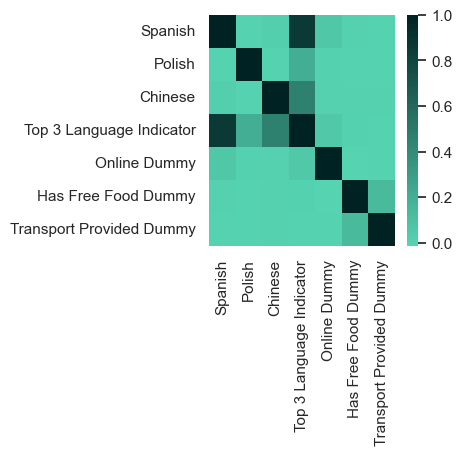

In [175]:
#plot correlation between each of the accessibility measures and each of the languages

sns.set(rc={'figure.figsize':(3,3)})
sns.heatmap(language_tracking.loc[:,['Spanish', 'Polish', 'Chinese', 'Top 3 Language Indicator', 'Online Dummy', 'Has Free Food Dummy', 'Transport Provided Dummy']].corr(), cmap=cmap)